In [78]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os
from plot_data import plot_sensor_measurement, plot_sensor_calibration, plot_wind_rose
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


start_date = datetime(2023, 10, 1, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 10, 8, 23, 59, 59).replace(tzinfo=timezone.utc)

sensor_id = 5

acropolis_path = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/acropolis/"
picarro_path = r"/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/PICARRO"

#Calibration
picarro_slope = 1.0061589132696314
picarro_intercept = 0.14607153970888476

acropolis_slope = 1.0186681346471844
acropolis_intercept = 2.287082983054006

In [79]:
df = pl.scan_parquet(os.path.join(acropolis_path, "pivot_measurements.parquet"))

df_a = df.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{sensor_id}" ).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_a = df_a.with_columns(((pl.col("gmp343_compensated")+15) * acropolis_slope + acropolis_intercept).alias("gmp343_compensated_corr"))


df_a.tail(3).collect()

system_name,revision,creation_timestamp,receipt_timestamp,gmp343_temperature,sht45_temperature,sht45_humidity,gmp343_compensated,gmp343_raw,bme280_humidity,bme280_temperature,gmp343_filtered,bme280_pressure,enclosure_bme280_temperature,raspi_memory_usage,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_cpu_usage,raspi_disk_usage,enclosure_bme280_humidity,wxt532_direction_avg,wxt532_speed_avg,wxt532_direction_min,wxt532_speed_max,wxt532_last_update_time,wxt532_speed_min,wxt532_direction_max,cal_bottle_id,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered,cal_bme280_temperature,cal_bme280_humidity,cal_bme280_pressure,cal_sht45_temperature,cal_sht45_humidity,cal_gmp343_temperature,gmp343_compensated_corr
str,i32,"datetime[ns, UTC]","datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""tum-esm-midcos…",27,2023-10-08 23:59:37.200 UTC,2023-10-08 23:59:38.441531 UTC,null,null,null,null,null,null,null,null,null,26.19,0.116,962.65,49.1,0.033,0.363,30.45,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""tum-esm-midcos…",27,2023-10-08 23:59:47.150 UTC,2023-10-08 23:59:47.408666 UTC,20.9,19.23,52.54,441.4,409.8,50.79,19.26,438.0,942.21,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,467.20722
"""tum-esm-midcos…",27,2023-10-08 23:59:57.150 UTC,2023-10-08 23:59:59.851 UTC,21.0,19.23,52.53,440.4,409.9,50.79,19.26,438.0,946.18,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,466.188552


In [80]:
df = pl.scan_parquet(os.path.join(picarro_path, "picarro.parquet"))
df = df.with_columns(pl.col("datetime").dt.cast_time_unit("ns").dt.replace_time_zone("UTC").alias("creation_timestamp"))

df_p = df.sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_p = df_p.with_columns((pl.col("CO2_dry") * picarro_slope + picarro_intercept).alias("CO2_corr"))

df_p.tail(3).collect()

DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,creation_timestamp,CO2_corr
str,str,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],i64,"datetime[ns, UTC]",f64
"""2023-10-08""","""23:59:57.234""",280.999968,6743.999232,281.999968,1.6968e9,0,963,140.005753,44.999687,40.8125,45.155113,2.0,22612.361328,2.026048,2.057768,445.308829,453.902584,1.526123,1180.472211,83.087488,1084.199129,65.422051,-0.074345,-0.044834,2023-10-08 23:59:57.234,281924,2023-10-08 23:59:57.234 UTC,456.844202
"""2023-10-08""","""23:59:58.141""",280.999978,6743.999484,281.999978,1.6968e9,0,963,140.005753,44.999687,40.8125,45.155113,1.0,22612.361328,2.026048,2.057768,445.295013,453.902584,1.526123,1180.472211,83.087488,1084.210887,51.772266,-0.074335,-0.044834,2023-10-08 23:59:58.141,281925,2023-10-08 23:59:58.141 UTC,456.844202
"""2023-10-08""","""23:59:58.642""",280.999984,6743.999623,281.999984,1.6968e9,0,963,140.006837,44.999687,40.8125,45.155113,3.0,22613.096454,2.026048,2.058041,445.295013,453.890718,1.526367,1180.472211,83.087488,1084.210887,51.772266,-0.074335,-0.044834,2023-10-08 23:59:58.642,281926,2023-10-08 23:59:58.642 UTC,456.832263


In [81]:
filter = '1h'

df_a = df_a.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

df_p = df_p.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

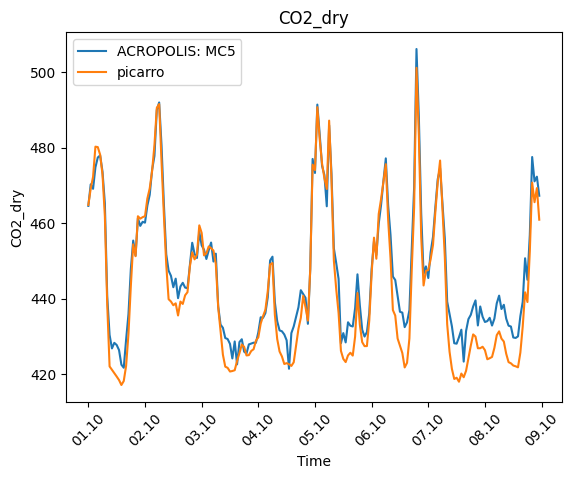

In [82]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="gmp343_compensated_corr", label = f"ACROPOLIS: MC{sensor_id}")
sns.lineplot(data=df_p.collect(), x="creation_timestamp", y="CO2_corr", label = "picarro")

# set axes labels
plt.xlabel("Time")
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

# show the plot
plt.show()

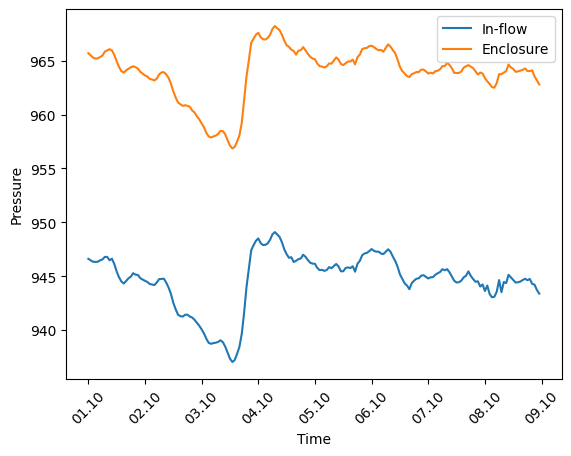

In [92]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="bme280_pressure", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_pressure", label = f"Enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Pressure')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

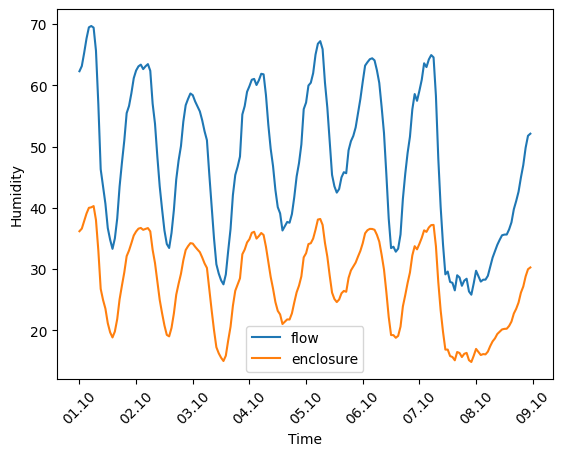

In [93]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_humidity", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_humidity", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Humidity')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

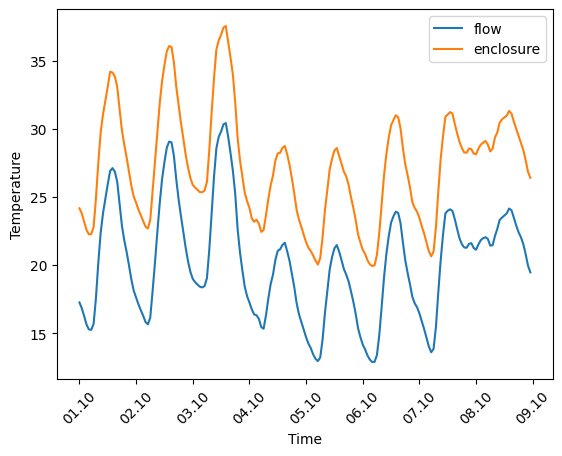

In [95]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_temperature", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_temperature", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

In [83]:
df = df_a.join(df_p, left_on= "creation_timestamp", right_on= "creation_timestamp")
df.tail(3).collect()

creation_timestamp,system_name,revision,receipt_timestamp,gmp343_temperature,sht45_temperature,sht45_humidity,gmp343_compensated,gmp343_raw,bme280_humidity,bme280_temperature,gmp343_filtered,bme280_pressure,enclosure_bme280_temperature,raspi_memory_usage,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_cpu_usage,raspi_disk_usage,enclosure_bme280_humidity,wxt532_direction_avg,wxt532_speed_avg,wxt532_direction_min,wxt532_speed_max,wxt532_last_update_time,wxt532_speed_min,wxt532_direction_max,cal_bottle_id,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered,cal_bme280_temperature,cal_bme280_humidity,cal_bme280_pressure,cal_sht45_temperature,cal_sht45_humidity,cal_gmp343_temperature,gmp343_compensated_corr,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,CO2_corr
"datetime[ns, UTC]",str,f64,"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
2023-10-08 21:00:00 UTC,null,27.0,null,22.428412,20.81468,49.817326,445.191086,412.499443,47.997911,20.839248,445.179666,944.220975,27.707037,0.254519,963.541481,50.822222,0.032444,0.363,28.814444,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,471.069078,null,null,280.896872,6741.524917,281.896872,1.6968e9,0.0,963.0,140.000004,44.999948,40.965487,45.155494,2.029827,22648.999318,2.041663,2.075151,453.475404,462.56698,1.581341,1180.648649,83.067364,1084.29116,59.643352,-0.074449,-0.044763,null,277106.0,465.561961
2023-10-08 22:00:00 UTC,null,27.0,null,21.633983,19.965543,51.756518,446.413649,414.988579,49.959694,19.993816,446.496936,943.735682,26.836071,0.112964,963.1775,49.446429,0.032036,0.363,29.978571,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,472.314464,null,null,280.937439,6742.498544,281.937439,1.6968e9,0.0,963.0,140.000017,44.999996,40.897497,45.155662,2.028747,22626.498904,2.051524,2.084795,457.198206,466.26799,1.566416,1180.631354,82.033777,1084.289279,59.993141,-0.074579,-0.044897,null,279035.5,469.285765
2023-10-08 23:00:00 UTC,null,27.0,null,21.205278,19.469611,52.0975,441.461111,411.13,50.349667,19.502833,441.653889,943.389639,26.406071,0.114821,962.792857,49.25,0.033571,0.363,30.272857,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,467.269472,null,null,280.979296,6743.503107,281.979296,1.6968e9,0.0,963.0,139.999949,45.000013,40.871023,45.155605,2.014606,22615.276214,2.029672,2.061855,449.255571,457.964171,1.531142,1180.591451,82.979035,1084.269157,59.661995,-0.074504,-0.044825,null,280968.0,460.930805


<Axes: xlabel='gmp343_compensated_corr', ylabel='CO2_corr'>

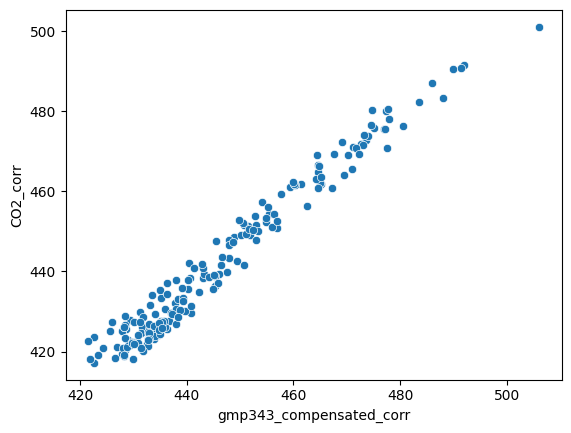

In [84]:
sns.scatterplot(data = df.collect(), x= "gmp343_compensated_corr", y = "CO2_corr" )